Exploring Segregation in NYC School
===================================
In 2014, the [_Civil Rights Project/Proyecto Derechos Civiles_](https://civilrightsproject.ucla.edu/) at UCLA released a report indicating that NYC had the most segregated schools in the nation. They followed up the 2014 report in 2021, finding that NYC was still last in terms of racial and ethnic integration of major school districts.

Since the 1950s the city has grappled with it separate and unequal school system, but the problems persist. Recently, activism around Black Lives Matter has re-invigorated the conversation, with student-led organizations like [Teens Take Charge](https://www.instagram.com/teenstakecharge/) playing a leading role. This brief report demonstrates some ways that we can use NYC open data to explore the shape of segregation in the city's schools.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

import scipy

from IPython.display import Markdown as md, HTML
from nycschools import schools, geo, ui, class_size


In [ ]:
# load common core of data for 2007-2008 to match the data in the journal article
# description of columns: https://nces.ed.gov/ccd/pdf/psu071bgen.pdf
ccd = pd.read_csv("ccod-2007.csv")
ccd.head()


In [6]:

ccd_nys = ccd[ccd["state"] == "NY"]
ccd_nys.county.unique()

array(['Herkimer', 'Oneida', 'St. Lawrence', 'Schenectady', 'Fulton',
       'Otsego', 'Steuben', 'Suffolk', 'Clinton', 'Schoharie', 'Allegany',
       'Madison', 'Seneca', 'Cattaraugus', 'Rensselaer', 'Chautauqua',
       'Chenango', 'Sullivan', 'Erie', 'Monroe', 'Nassau', 'Albany',
       'New York', 'Kings', 'Bronx', 'Queens', 'Onondaga', 'Richmond',
       'Cayuga', 'Chemung', 'Columbia', 'Dutchess', 'Franklin', 'Greene',
       'Jefferson', 'Livingston', 'Orange', 'Orleans', 'Saratoga',
       'Schuyler', 'Ulster', 'Washington', 'Wayne', 'Westchester',
       'Wyoming', 'Essex', 'Broome', 'Rockland', 'Delaware', 'Tompkins',
       'Genesee', 'Niagara', 'Warren', 'Oswego', 'Montgomery', 'Lewis',
       'Ontario', 'Putnam', 'Tioga', 'Cortland', 'Yates', 'Hamilton', 'N'],
      dtype=object)

In [4]:
# load the demographic data and get just the most recent year and columns of interest
df = schools.load_school_demographics()
segregation_cols = ['dbn', 'district',  'school_name', 'total_enrollment',
        'asian_n', 'asian_pct', 'black_n', 'black_pct', 'hispanic_n',
        'hispanic_pct', 'white_n', 'white_pct', 'poverty_n', 'poverty_pct']
data = df[df.ay == df.ay.max()].copy()
data = data[segregation_cols]

Measures of Segregation
=======================
Intense Segregation and Apartheid Schools
-----------------------------------------
One simple measure used in the UCLA report considers schools with >90% non-white students as **intensely segregated** and schools with 99% non-white students as **apartheid schools**. We can quickly look at the most recent demographic data in our set to see what these two measures look like. In the code below we:

1. Calculate non-white enrollment and percent
2. Add an `intense_seg` category (True or False)
3. Add an `apartheid` category

In [6]:
# add some columns related to our analysis
data["nonwhite_n"] = data.total_enrollment - data.white_n
data["nonwhite_pct"] = 1 - data.white_pct
data["black_hispanic_n"] = data.black_n + data.hispanic_n
data["black_hispanic_pct"] = data.black_pct + data.hispanic_pct

data["intense_seg"] = (data.nonwhite_pct >= .90)
data["apartheid"] = data.nonwhite_pct >= .99

# pull out the data so we can show it in a table
seg_schools = len(data[data.intense_seg == True])
apart_schools = len(data[data.apartheid == True])
num_schools = data.dbn.count()
rep_schools = num_schools - seg_schools
total_students = data.total_enrollment.sum()
rep_students = data[data.intense_seg == False].total_enrollment.sum()
seg_students = data[data.intense_seg == True].total_enrollment.sum()
apart_students = data[data.apartheid == True].total_enrollment.sum()


seg = pd.DataFrame({
    "School Group": ["NYC Total", "More Representative", "Intense Segregated", "Apartheid"],
    "Total Students": [f"{total_students:,}", f"{rep_students:,}", f"{seg_students:,}", f"{apart_students:,}"],
    "% of City Students": ["100%", f"{rep_students/total_students:.1%}", f"{seg_students/total_students:.1%}", f"{apart_students/total_students:.1%}"]
})
display(seg)
md(f"""
**Overview of school segregation in NYC**

- In 2020-21 there were {num_schools:,} schools in NYC with {total_students:,} students.
- {seg_schools:,} schools were intensely segregated, enrolling {seg_students:,} students.
- In addition, {apart_schools:,} of these schools were "apartheid" schools
  with populations of more than 99% non-White students, enrolling {apart_students:,} students.
""")


,School Group,Total Students,% of City Students
0,NYC Total,"1,148,504",100%
1,More Representative,"451,553",39.3%
2,Intense Segregated,"696,951",60.7%
3,Apartheid,"151,148",13.2%



**Overview of school segregation in NYC**

- In 2020-21 there were 2,048 schools in NYC with 1,148,504 students.
- 1,413 schools were intensely segregated, enrolling 696,951 students.
- In addition, 302 of these schools were "apartheid" schools
  with populations of more than 99% non-White students, enrolling 151,148 students.


10% Representative
------------------
One measure of segregation used by the DeBlasio administration's "School Diversity Advisory Group (SDAG)" was to look to see if a school's ethnic/racial percentages are within 10% of the mean for the district's averages.

In [9]:
agg = {
    "total_enrollment": "sum",
    "intense_seg": "sum",
    "apartheid": "sum",
}

# avg the cols that end in _pct
for col in data.columns:
    if col.endswith("_pct"):
        agg[col] = "mean"
districts = data[["district"] + list(agg.keys())].groupby("district").agg(agg).reset_index()
display(districts[["district","total_enrollment","poverty_pct","nonwhite_pct"]].sort_values("district"))

for col in districts.columns:
    if col.endswith("_pct"):
        districts[col] = districts[col] * 100


,district,total_enrollment,poverty_pct,nonwhite_pct
0,1,10553,0.722000,0.857481
1,2,73667,0.561564,0.752685
2,3,24943,0.568660,0.743191
3,4,11754,0.826345,0.948241
4,5,12223,0.790735,0.913029
5,6,19167,0.845717,0.938761
6,7,16672,0.915714,0.985190
7,8,26180,0.852545,0.950655
8,9,31605,0.918842,0.985211
9,10,54253,0.861495,0.954695


School Choice
=============
The UCLA report finds that school choice, as implemented in NYC Public Schools, does not lead to lower levels of segregation. There are many types of choice in NYC schools, including charter schools, gifted and talented programs (G&T), specialized schools, and city wide admissions systems for middle and high school.

Charter Schools
----------------
Public charter schools offer alternative choices to community schools. Supporters of charter schools hope that these schools offer a "way out" for students facing grim opportunities in their "zoned" local schools. If we look at the data, though, charters exacerbate rather than relieve issues of race/ethnic segregation. In the code below we use a t-test to see if the percentage of black and hispanic students in charter schools is different from the percentage in community schools.

In [9]:
data = df.copy()
data["black_hispanic_n"] = data.black_n + data.hispanic_n
data["black_hispanic_pct"] = data.black_pct + data.hispanic_pct

community = data[data.school_type == "community"]
charter = data[data.school_type == "charter"]

# drop null rows
community = community[community.black_hispanic_pct.notnull()]
charter = charter[charter.black_hispanic_pct.notnull()]

# t-test between community and charter schools
t = scipy.stats.ttest_ind(charter.black_hispanic_pct, community.black_hispanic_pct)
# population size
n_charter = len(charter)
n_community = len(community)

# mean average
M_charter = charter.black_hispanic_pct.mean()
M_community = community.black_hispanic_pct.mean()

# standard deviation 
sd_charter = charter.black_hispanic_pct.std()
sd_community = community.black_hispanic_pct.std()

charter_enroll = charter[charter.ay == data.ay.max()].total_enrollment.sum()
# total not counting D75 and alt schools
total_enroll = charter_enroll + community[community.ay == community.ay.max()].total_enrollment.sum() 
charter_pct = charter_enroll / total_enroll

display(md(f"""
### Charter schools have a higher percentage of Black/Hispanic students
{charter_enroll:,} students attend charter schools in NYC.
Charter school students make up {charter_pct:.1%} of 
the total student population (excluding D75 and alternative school students).

**T-Test results** comparing school averages of 
Charter School % Black/Hispanic (`n={n_charter}`) 
and Community School % Black/Hispanic (`n={n_community}`).

- Charter % Black/Hispanic: M={M_charter:.02%}, SD={sd_charter:.02%}
- Community % Black/Hispanic: M={M_community:.02%}, SD={sd_community:.02%}
- T-score: {t.statistic:.04f}, p-val: {t.pvalue:.04f}

`n` values report the number of schools observed, not the number of students. 
"""))




### Charter schools have a higher percentage of Black/Hispanic students
148,617 students attend charter schools in NYC.
Charter school students make up 13.4% of 
the total student population (excluding D75 and alternative school students).

**T-Test results** comparing school averages of 
Charter School % Black/Hispanic (`n=1256`) 
and Community School % Black/Hispanic (`n=8360`).

- Charter % Black/Hispanic: M=89.62%, SD=13.54%
- Community % Black/Hispanic: M=71.01%, SD=28.50%
- T-score: 22.7578, p-val: 0.0000

`n` values report the number of schools observed, not the number of students. 


High School Admissions
----------------------
High school admissions have been a particularly contested area of school policy in terms of choice, academics, and segregation. The eight schools specialized high schools that rely solely on the SHSAT entrance exam have drawn fire for the shockingly low numbers of Black and Latinx students they admit. Similarly, the city's most selective "screened" high schools use a variety of admissions policies to select students, often with admissions rates lower than Ivy League universities.

### SHSAT School Populations

,School,Asian,White,Black,Hispanic,Total
8219,Staten Island Technical High School,760,487,9,57,1336
7304,Queens High School for the Sciences at York Co...,427,22,17,20,511
2999,High School of American Studies at Lehman College,88,174,27,61,382
1428,"High School for Mathematics, Science and Engin...",152,139,45,92,496
656,Stuyvesant High School,2386,587,47,126,3342
2955,The Bronx High School of Science,1891,614,95,229,2936
3939,"Brooklyn Latin School, The",444,108,104,86,808
3723,Brooklyn Technical High School,3545,1401,334,391,5921


**Table: Total students in SHSAT schools, by race/ethnicity**

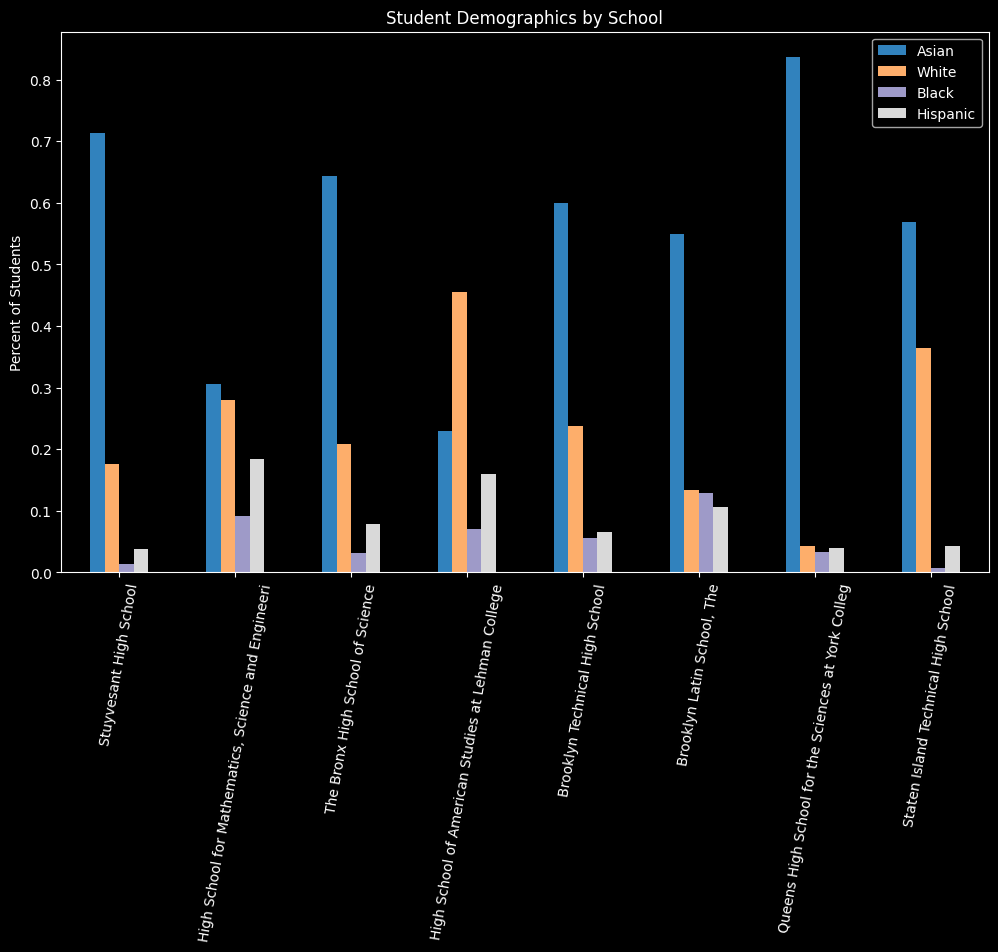

In [24]:
shsat_schools = ['02M475', '05M692', '10X445', '10X696', '13K430', '14K449', '28Q687', '31R605']
shsat = df[df.ay == df.ay.max()].copy()
shsat = shsat[shsat.dbn.isin(shsat_schools)]
shsat = shsat[segregation_cols].drop_duplicates()

table = shsat[["school_name", "asian_n", "white_n", "black_n", "hispanic_n", "total_enrollment"]].sort_values(by="black_n")
table.columns = ["School", "Asian", "White", "Black", "Hispanic", "Total"]
display(table)
display(md("**Table: Total students in SHSAT schools, by race/ethnicity**"))

# get the columns we want and rename them for the graph
cols = ['school_name', 'asian_pct', 'white_pct', 'black_pct', 'hispanic_pct']
pretty_cols = ['School', 'Asian', 'White', 'Black', 'Hispanic']
chart = shsat[cols]
chart.columns = pretty_cols

# # create the graph
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout()
_ = chart.plot(ax=ax, kind="bar", x="School", stacked=False, cmap="tab20c",
               rot=80, title="Student Demographics by School", xlabel="", ylabel="Percent of Students")




High School Choice
------------------

In [17]:
hs_dir = schools.load_hs_directory()


In [42]:
def total_grade9_seats(row):
    seats = 0
    for i in range(1, 12):
        try:
            seats += int(row[f"seats9ge{i}"])
        except:
            pass
    return seats


def total_grade9_applicants(row):
    applicants = 0
    for i in range(1, 12):
        try:
            applicants += int(row[f"grade9geapplicants{i}"])
        except:
            pass
    return applicants

hs_dir["grade9_seats"] = hs_dir.apply(total_grade9_seats, axis=1)
hs_dir["grade9_applicants"] = hs_dir.apply(total_grade9_applicants, axis=1)
hs_dir["applicants_per_seat"] = round(hs_dir.grade9_applicants / hs_dir.grade9_seats)
hs_dir = hs_dir.dropna(subset=['applicants_per_seat'])
hs_dir["applicants_per_seat"] = hs_dir.applicants_per_seat.astype(int)
hs_dir["percentile"] = pd.qcut(hs_dir.applicants_per_seat, q=10, labels=False, duplicates="drop")
top_hs = hs_dir[['dbn','school_name', 'applicants_per_seat', 'percentile']]
top_hs = top_hs.sort_values(by="applicants_per_seat", ascending=False).head(10)
display(top_hs)
md("**Table: Top 10 schools with the most applicants per seat**")


,dbn,school_name,applicants_per_seat,percentile
31,02M411,Baruch College Campus High School,64,8
84,03M541,Manhattan / Hunter Science High School,60,8
96,05M362,Columbia Secondary School,54,8
35,02M416,Eleanor Roosevelt High School,54,8
45,02M439,Manhattan Village Academy,53,8
4,01M539,"New Explorations into Science, Technology and ...",50,8
371,26Q430,Francis Lewis High School,50,8
90,04M555,Central Park East High School,48,8
235,13K595,Bedford Academy High School,48,8
36,02M418,Millennium High School,47,8


**Table: Top 10 schools with the most applicants per seat**

In [41]:
top_hs.drop(columns=["school_name"], inplace=True)
top_hs = top_hs.merge(df[df.ay == df.ay.max()], on="dbn", how="inner")
top_hs = top_hs[segregation_cols].drop_duplicates()
# top_hs
top_hs

KeyError: "['district', 'total_enrollment', 'asian_n', 'asian_pct', 'black_n', 'black_pct', 'hispanic_n', 'hispanic_pct', 'white_n', 'white_pct', 'poverty_n', 'poverty_pct'] not in index"

In [ ]:

table = shsat[["school_name", "asian_n", "white_n", "black_n",
               "hispanic_n", "total_enrollment"]].sort_values(by="black_n")
table.columns = ["School", "Asian", "White", "Black", "Hispanic", "Total"]
display(table)
display(md("**Table: Total students in SHSAT schools, by race/ethnicity**"))

# get the columns we want and rename them for the graph
cols = ['school_name', 'asian_pct', 'white_pct', 'black_pct', 'hispanic_pct']
pretty_cols = ['School', 'Asian', 'White', 'Black', 'Hispanic']
chart = shsat[cols]
chart.columns = pretty_cols

# # create the graph
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout()
_ = chart.plot(ax=ax, kind="bar", x="School", stacked=False, cmap="tab20c",
               rot=80, title="Student Demographics by School", xlabel="", ylabel="Percent of Students")


Index of dissimilarity
----------------------

`D` is the _index of dissimilarity_ which is an "index of unevenness segregation." For our data D measures the unevenness of ethnic/racial distribution across schools. Higher values of D indicate that groups are not spread evenly across schools (more segregation), lower values indicate an even distribution of the population (less segregation). 1 would be perfectly segregated while 0 would be perfectly proportionate distribution. Below we calculate D for each district and then for the entire school system. We find that some districts have a low D index, where it is higher than the city index in other districts. This measure is based on Allen, R., and Vignoles, A. (2007) and Frankel, D. M., and Volij, O. (2011).

We create a function to calculate the D index for a school based on a set of data. We can use this to find unenveness with a geographic school district and/or within the whole city.


In [11]:
# calculate unevenness

def calculate_dissimilarity(data):
    total_black = data['black_n'].sum()
    total_white = data['white_n'].sum()
    total_asian = data['asian_n'].sum()
    total_hispanic = data['hispanic_n'].sum()

    total = data.total_enrollment.sum()

    non_black = total - total_black
    non_white = total - total_white
    non_asian = total - total_asian
    non_hispanic = total - total_hispanic

    def diss(row, eth, eth_total, total):
        cols = list(row.index)
        # the total students in the school outside of the target ethnic group `eth`
        non_eth = sum([row[col] for col in cols if col != eth and col.endswith('_n')])
        D = (row[eth] / eth_total) - (non_eth / total)
        return abs(D)

    black_D = data.apply(partial(diss, eth="black_n", eth_total=total_black, total=non_black), axis=1)
    black_D = black_D.sum() / 2

    white_D = data.apply(partial(diss, eth="white_n", eth_total=total_white, total=non_white), axis=1)
    white_D = white_D.sum() / 2

    asian_D = data.apply(partial(diss, eth="asian_n", eth_total=total_asian, total=non_asian), axis=1)
    asian_D = asian_D.sum() / 2

    hispanic_D = data.apply(partial(diss, eth="hispanic_n", eth_total=total_hispanic, total=non_hispanic), axis=1)
    hispanic_D = hispanic_D.sum() / 2

    # calculated a weighted average of the D indices
    weights = [data.asian_pct.mean(), data.black_pct.mean(), data.hispanic_pct.mean(), data.white_pct.mean()]
    D = np.average([asian_D, black_D, hispanic_D, white_D], weights=weights)
    
    return D

cols = ['dbn', 'district', 'boro', 'total_enrollment', 'black_n', 'white_n', 'asian_n',
        'hispanic_n', 'black_pct', 'white_pct', 'asian_pct', 'hispanic_pct']
data = df[cols].copy()
data.set_index('dbn', inplace=True)
seg_D = pd.DataFrame()
seg_D['district'] = data.district.unique()
seg_D['D'] = seg_D.district.apply(lambda x: calculate_dissimilarity(data[data.district == x]))
nyc_D = calculate_dissimilarity(data)
seg_D = seg_D.sort_values('D', ascending=False)
print("City D", nyc_D)

City D 0.4951746899047429


In [12]:
agg = {
    'boro': 'first',
    'total_enrollment': 'sum',
    'black_n': 'sum',
    'white_n': 'sum',
    'asian_n': 'sum',
    'hispanic_n': 'sum',
    'black_pct': 'mean',
    'white_pct': 'mean',
    'asian_pct': 'mean',
    'hispanic_pct': 'mean'
}
t = data.groupby('district').agg(agg).reset_index()
t = t.merge(seg_D, on='district', how='inner')

del agg['boro']
nyc = data.aggregate(agg)

nyc = pd.DataFrame(nyc).T
nyc = nyc.reset_index()
nyc['district'] = 0
nyc['boro'] = 'NYC Schools'
nyc['D'] = nyc_D
nyc[t.columns]
table = pd.concat([t, nyc[t.columns]])
m = {75:"SWD", 84:"Charter Schools", 79:"Alternative District"}
table.boro = table.apply(lambda x: x.boro if x.district < 33 else m[x.district], axis=1)
# table.set_index("district")

References
============

Allen, R., & Vignoles, A. (2007). What should an index of school segregation measure? _Oxford Review of Education_, _33_(5), 643–668. https://doi.org/10.1080/03054980701366306

Cohen, D. (2021). NYC School Segregation Report Card: Still Last, Action Needed Now! _Civil Rights Project/Proyecto Derechos Civiles_. UCLA. https://escholarship.org/uc/item/5fx616qn

Frankel, D. M., & Volij, O. (2011). Measuring school segregation. _Journal of Economic Theory_, _146_(1), 1–38. https://doi.org/10.1016/j.jet.2010.10.008

Lauren Lefty. (2021, February 11). [The Long Fight for Educational Equity in NYC](https://www.mcny.org/story/long-fight-educational-equity-nyc). _Museum of the City of New York_.

Zhang, C. H., & Ruther, M. (2021). Contemporary patterns and issues of school segregation and white flight in U.S. metropolitan areas: Towards spatial inquiries. _GeoJournal_, _86_(3), 1511–1526. https://doi.org/10.1007/s10708-019-10122-1
